In [27]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
spot_init=100
int_rate=2/100
volatility=15/100
maturity=1
nb_step=12
time_step= maturity/nb_step
nb_path=20
nb_seed=20191008

In [3]:
drift_mod= (int_rate-0.5*volatility**2)*time_step
mat_drift= drift_mod*np.cumsum(np.ones((nb_path,nb_step)),axis=1)
volat_mod= volatility*np.sqrt(time_step)
np.random.seed(nb_seed)
mat_shock= np.random.standard_normal((nb_path,nb_step))
mat_shock_cum= np.cumsum(mat_shock,axis=1)
mat_volatility= volat_mod*mat_shock_cum
mat_log_spot= mat_drift+mat_volatility
mat_spot_init= spot_init*np.ones((nb_path,nb_step))
mat_spot_fut= mat_spot_init*np.exp(mat_log_spot)
vec_spot_init= spot_init*np.ones((nb_path,1))
mat_path_spot_fut= np.concatenate((vec_spot_init,np.round(mat_spot_fut,3)),axis=1)

In [4]:
mat_path_spot_fut;

In [5]:
def implied_malz_vol(spot,tt_maturity,strike,int_rate):
    alpha_1 = 0.58
    alpha_2 = -0.35
    #vol = volatility + (alpha_1/np.sqrt(tt_maturity))*np.log(spot*np.exp(int_rate*tt_maturity)/strike) + alpha_2*((1/np.sqrt(tt_maturity))*np.log(spot*np.exp(int_rate*tt_maturity)/strike))**2
    malz_vol = volatility + (alpha_1/np.sqrt(tt_maturity))*np.log(spot*np.exp(int_rate*tt_maturity)/strike) + alpha_2*((1/np.sqrt(tt_maturity))*np.log(spot*np.exp(int_rate*tt_maturity)/strike))**2
    return max(5/100,malz_vol)

In [6]:
def comp_price_call(mat_spot,strike,int_rate):
    mat_price_call = np.zeros((nb_path,nb_step+1))
    for i in range(nb_path):
        for j in range(nb_step+1):
            if j == 12:
                mat_price_call[i,j] = max(mat_spot[i,j] - strike,0)
            else:
                discount= np.exp(-int_rate*(nb_step-j)/nb_step)
                volatility = implied_malz_vol(mat_spot[i,j],(nb_step-j)/nb_step,strike,int_rate)
                volat_mod = volatility*np.sqrt((nb_step-j)/nb_step)
                moneyness= np.log(mat_spot[i,j]/strike)
                term_vol= (int_rate+0.5*volatility**2)*(nb_step-j)/nb_step
                d1=(moneyness+term_vol)/volat_mod
                d2=d1-volat_mod
                prob_d1=norm.cdf(d1)
                prob_d2=norm.cdf(d2)
                mat_price_call[i,j] = mat_spot[i,j]*prob_d1-discount*strike*prob_d2
    return mat_price_call 

def comp_delta_call(mat_spot,strike,int_rate):
    mat_delta_call = np.zeros((nb_path,nb_step))
    for i in range(nb_path):
        for j in range(nb_step):
            if j == 12 :
                if mat_spot[i,j] > strike :
                    mat_delta_call[i,j] = 1
                else :
                    mat_delta_call[i,j] = 0
            else : 
                volatility = implied_malz_vol(mat_spot[i,j],(nb_step-j)/nb_step,strike,int_rate)
                volat_mod= volatility*np.sqrt((nb_step-j)/nb_step)
                moneyness= np.log(mat_spot[i,j]/strike)
                term_vol= (int_rate+0.5*volatility**2)*(nb_step-j)/nb_step
                d1=(moneyness+term_vol)/volat_mod
                prob_d1=norm.cdf(d1)
                mat_delta_call[i,j] =prob_d1
    return mat_delta_call

## Question 1 & 3

In [7]:
mat_call_price = comp_price_call(mat_path_spot_fut,100,int_rate)
mat_call_delta = comp_delta_call(mat_path_spot_fut,100,int_rate)

In [8]:
mat_call_delta;

In [9]:
np.shape(mat_call_price)

(20, 13)

In [10]:
for i in range(nb_path):
    for j in range(nb_step+1):
        mat_call_price[i,j] = round(mat_call_price[i,j],2)

In [11]:
for i in range(nb_path):
    for j in range(nb_step):
        mat_call_delta[i,j] = round(mat_call_delta[i,j],3)

In [12]:
mat_call_delta;

## Question 2

In [13]:
pnl_non_covered = np.zeros(nb_path)
nb_calls = 10000
for i in range(nb_path):
    if 100 < mat_path_spot_fut[i,-1]:
        pnl_non_covered[i] = round(nb_calls*mat_call_price[i,0]*(1-0.2/100) - nb_calls*(mat_path_spot_fut[i,-1] - 100) - nb_calls*mat_path_spot_fut[i,-1]*0.5/100 - nb_calls*100*0.5/100,2)
    else:
        pnl_non_covered[i] =  round(nb_calls*mat_call_price[i,0]*(1-0.2/100),2)

In [14]:
pnl_non_covered

array([  53298.8 ,   73951.8 , -146736.4 ,   73951.8 ,   73951.8 ,
         73951.8 , -105873.1 ,   60544.85,   73951.8 ,   73951.8 ,
         73951.8 ,   73951.8 ,   73951.8 ,   73951.8 ,   73951.8 ,
       -133671.4 ,  -75039.7 ,   41610.65,    7078.85, -198956.2 ])

## Question 4

In [15]:
stocks_to_hold = np.zeros((nb_path,nb_step))

for i in range(nb_path):
    for j in range(nb_step):
        '''if j == 0:
            stocks_to_hold[i,j] = mat_call_price[i,j]/(mat_call_delta[i,j]*mat_spot_fut[i,j])
        else:
            stocks_to_hold[i,j] = round((mat_call_price[i,j] - mat_call_price[i,j-1])/(mat_call_delta[i,j]*(mat_spot_fut[i,j]-mat_spot_fut[i,j-1])))'''
        stocks_to_hold[i,j] = round(nb_calls*mat_call_delta[i,j])

In [16]:
stocks_to_hold;

## Question 5

In [17]:
pnl_covered = np.zeros(nb_path)
nb_calls = 10000
for i in range(nb_path):
    borrowing_init = nb_calls*mat_call_price[i,0]*(1-0.2/100) - stocks_to_hold[i,0]*mat_path_spot_fut[i,0]*(1+0.5/100)
    borrowing = borrowing_init
    adjustments = stocks_to_hold[i,-1]*(mat_path_spot_fut[i,-1]-mat_path_spot_fut[i,nb_step-1])
    for j in range(1,nb_step):
        borrowing_bar = nb_calls*(mat_call_price[i,j-1]-mat_call_price[i,j]) + stocks_to_hold[i,j-1]*(mat_path_spot_fut[i,j] - mat_path_spot_fut[i,j-1])+ time_step*int_rate*borrowing_init
        borrowing_current = borrowing_bar + (stocks_to_hold[i,j-1]-stocks_to_hold[i,j])*mat_path_spot_fut[i,j]- abs(stocks_to_hold[i,j-1]-stocks_to_hold[i,j])*mat_path_spot_fut[i,j]*0.5/100
        borrowing += borrowing_current
        borrowing_init = borrowing_current
        adjustments += stocks_to_hold[i,j-1]*(mat_path_spot_fut[i,j]-mat_path_spot_fut[i,j-1])
    pnl_covered[i] =  round(nb_calls*(mat_call_price[i,0] - mat_call_price[i,-1]) + adjustments + time_step*int_rate*borrowing,2)
    if 100 < mat_path_spot_fut[i,-1]:
        pnl_covered[i] -= round(nb_calls*100*0.5/100 + (nb_calls-stocks_to_hold[i,-1])*mat_path_spot_fut[i,-1]*(1+0.5/100),2)
    else:
        pnl_covered[i] -= round(stocks_to_hold[i,-1]*mat_path_spot_fut[i,-1]*0.5/100,2)

In [18]:
pnl_covered

array([-164384.32,   14959.08,  -68651.03,   25803.49,    8580.69,
         17022.95, -135528.79, -992356.1 ,  -11031.16,   27570.12,
         16258.51,   20006.26,   28095.34,   22864.8 ,   18933.79,
        -62144.19, -103566.  , -745658.67, -123944.95, -144557.16])

Text(0.5, 1.0, 'Covered and non covered strategies pnl')

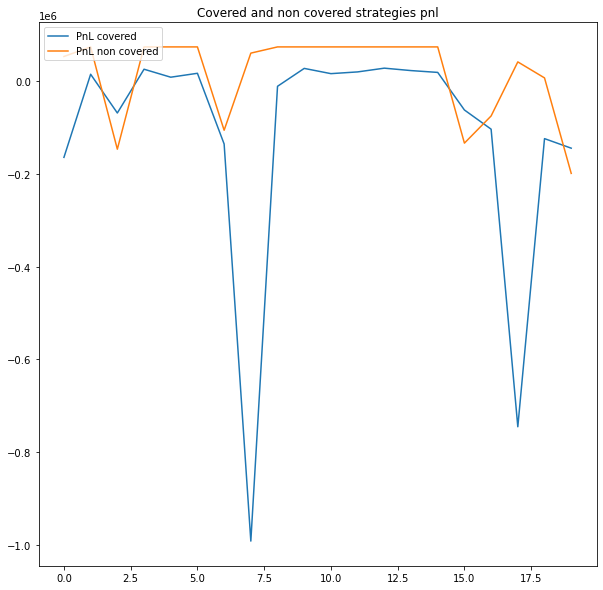

In [19]:
plt.figure(figsize=(10,10))
ax1 = plt.plot(pnl_covered,label="PnL covered")
ax2 = plt.plot(pnl_non_covered,label="PnL non covered")
plt.legend(loc="upper left")
plt.title("Covered and non covered strategies pnl")

## Question 6

In [70]:
nb_calls = 10000
stocks_to_hold_optim = np.zeros((nb_path,nb_step))
exp_call_zero = np.sum(mat_call_price[:,1])/20
exp_spot_zero = np.sum(mat_path_spot_fut[:,1])/20

for i in range(nb_path):
    borrowing_bar_vect = np.zeros((nb_step+1))
    
    for j in range(1,nb_step+1):
        borrowing_bar_candidates = np.zeros((nb_calls))
        borrowing_bar_toapp = np.zeros((nb_calls))
        borrowing_bar_candidates = [-np.inf for i in range(nb_calls)]
        proba = [np.exp(-1*abs(mat_path_spot_fut[l,j]-mat_path_spot_fut[i,j])) for l in range(nb_path)]
        proba /= np.sum(proba)
        exp_call = np.sum(mat_call_price[:,j]*proba)
        exp_spot = np.sum(mat_path_spot_fut[:,j]*proba)
        check = 0
        for trial in range(1,nb_calls):
            if exp_spot - mat_path_spot_fut[i,j-1] == 0:
                if j == 1 or j == nb_step:
                    check = 1
                    pass
                else:
                    if abs(borrowing_bar_vect[j-1] + (stocks_to_hold_optim[i,j-2] - trial)*mat_path_spot_fut[i,j-1] - abs(stocks_to_hold_optim[i,j-2] - trial)*mat_path_spot_fut[i,j-1]*0.5/100) <= mat_path_spot_fut[i,j-1]*stocks_to_hold_optim[i,j-2]*0.01 :
                        check = 1
                        pass
                    else:
                        continue
            else : 
                if j == 1 or j == nb_step:
                    check = 1
                    pass
                else:
                    if np.abs(time_step*int_rate*borrowing_bar_vect[j-1] - nb_calls*(exp_call-mat_call_price[i,j-1]) + trial*(exp_spot-mat_path_spot_fut[i,j-1])) <= nb_calls*mat_call_price[i,j-1]*0.01 :
                        check = 1
                        pass
                    else:
                        continue
            if j == 1:
                borrowing_bar_candidates[trial] = nb_calls*(mat_call_price[i,j-1]-exp_call_zero) + trial*(exp_spot_zero- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(nb_calls*mat_call_price[i,j-1]*(1-0.2/100)-trial*mat_path_spot_fut[i,j-1]*(1+0.5/100))
                borrowing_bar_toapp[trial] = nb_calls*(mat_call_price[i,j-1]-mat_call_price[i,j]) + trial*(mat_path_spot_fut[i,j]- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(nb_calls*mat_call_price[i,j-1]*(1-0.2/100)-trial*mat_path_spot_fut[i,j-1]*(1+0.5/100))

            elif j == nb_step:
                term1_exec = np.sum([trial*mat_path_spot_fut[o,j]*proba[o]*0.5/100 if mat_path_spot_fut[o,j] < 100 else 0 for o in range(nb_path)])
                term2_exec = np.sum([(nb_calls*100*0.5/100 + (nb_calls-trial)*(1+0.5/100)*mat_path_spot_fut[a,j])*proba[a] if mat_path_spot_fut[a,j] > 100 else 0 for a in range(nb_path)])
                borrowing_bar_candidates[trial] = nb_calls*(mat_call_price[i,j-1]-exp_call) + trial*(exp_spot- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(borrowing_bar_vect[j-1]+(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]-abs(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]*0.5/100) - term1_exec - term2_exec
                if mat_path_spot_fut[i,j] < 100 : 
                    borrowing_bar_toapp[trial] = nb_calls*(mat_call_price[i,j-1]-mat_call_price[i,j]) + trial*(mat_path_spot_fut[i,j]- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(borrowing_bar_vect[j-1]+(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]-abs(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]*0.5/100) - trial*mat_path_spot_fut[i,j] 
                else :
                    borrowing_bar_toapp[trial] = nb_calls*(mat_call_price[i,j-1]-mat_call_price[i,j]) + trial*(mat_path_spot_fut[i,j]- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(borrowing_bar_vect[j-1]+(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]-abs(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]*0.5/100) - (nb_calls*100 + (nb_calls-trial)*mat_path_spot_fut[i,j]*(1+0.5/100))

            else :
                borrowing_bar_candidates[trial] = nb_calls*(mat_call_price[i,j-1]-exp_call) + trial*(exp_spot- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(borrowing_bar_vect[j-1]+(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]-abs(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]*0.5/100)
                borrowing_bar_toapp[trial] = nb_calls*(mat_call_price[i,j-1]-mat_call_price[i,j]) + trial*(mat_path_spot_fut[i,j]- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(borrowing_bar_vect[j-1]+(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]-abs(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]*0.5/100)
        if check == 1:
            stocks_to_hold_optim[i,j-1] = np.argmax(borrowing_bar_candidates)
            borrowing_bar_vect[j] = borrowing_bar_toapp[np.argmax(borrowing_bar_candidates)]
        else:
            stocks_to_hold_optim[i,j-1] = 1
            borrowing_bar_vect[j] = nb_calls*(mat_call_price[i,j-1]-mat_call_price[i,j]) + (mat_path_spot_fut[i,j]- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(borrowing_bar_vect[j-1]+(stocks_to_hold_optim[i,j-2]-1)*mat_path_spot_fut[i,j-1]-abs(stocks_to_hold_optim[i,j-2]-1)*mat_path_spot_fut[i,j-1]*0.5/100)

In [71]:
pd.DataFrame(stocks_to_hold_optim)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,8535.0,7531.0,3007.0,6362.0,1.0,7594.0,8730.0,8280.0,9794.0,1.0,9999.0
1,1.0,9793.0,8371.0,4180.0,365.0,1.0,1.0,1.0,1.0,1.0,1.0,9999.0
2,1.0,1.0,5819.0,8321.0,4747.0,3816.0,5445.0,6963.0,8111.0,8664.0,8925.0,9999.0
3,1.0,5908.0,1.0,6196.0,1.0,8702.0,3101.0,9334.0,3185.0,1.0,1.0,9999.0
4,1.0,4893.0,282.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9999.0
5,1.0,1.0,7936.0,9886.0,2422.0,1.0,1.0,1.0,1.0,1.0,1.0,9999.0
6,1.0,1.0,8035.0,1609.0,7980.0,7001.0,5847.0,8708.0,1.0,1.0,7734.0,9999.0
7,1.0,1.0,7112.0,6749.0,9506.0,1.0,7189.0,3446.0,5796.0,9095.0,3434.0,9999.0
8,1.0,5650.0,1.0,7236.0,5481.0,6125.0,1.0,7776.0,1841.0,1.0,1.0,1.0
9,1.0,7854.0,7881.0,9611.0,8696.0,8901.0,1.0,9702.0,7062.0,1.0,1.0,9999.0


In [61]:
x = np.array([1,4,2])
x[0]

1

In [47]:
pnl_covered_optim = np.zeros(nb_path)
nb_calls = 10000
for i in range(nb_path):
    borrowing_init = nb_calls*mat_call_price[i,0]*(1-0.2/100) - stocks_to_hold_optim[i,0]*mat_path_spot_fut[i,0]*(1+0.5/100)
    borrowing = borrowing_init
    adjustments = stocks_to_hold_optim[i,-1]*(mat_path_spot_fut[i,-1]-mat_path_spot_fut[i,nb_step-1])
    for j in range(1,nb_step):
        borrowing_bar = nb_calls*(mat_call_price[i,j-1]-mat_call_price[i,j]) + stocks_to_hold_optim[i,j-1]*(mat_path_spot_fut[i,j] - mat_path_spot_fut[i,j-1])+ time_step*int_rate*borrowing_init
        borrowing_current = borrowing_bar + (stocks_to_hold_optim[i,j-1]-stocks_to_hold_optim[i,j])*mat_path_spot_fut[i,j]- abs(stocks_to_hold_optim[i,j-1]-stocks_to_hold_optim[i,j])*mat_path_spot_fut[i,j]*0.5/100
        borrowing += borrowing_current
        borrowing_init = borrowing_current
        adjustments += stocks_to_hold_optim[i,j-1]*(mat_path_spot_fut[i,j]-mat_path_spot_fut[i,j-1])
    pnl_covered_optim[i] =  round(nb_calls*(mat_call_price[i,0] - mat_call_price[i,-1]) + adjustments + time_step*int_rate*borrowing,2)
    if 100 < mat_path_spot_fut[i,-1]:
        pnl_covered_optim[i] -= round(nb_calls*100*0.5/100 + (nb_calls-stocks_to_hold_optim[i,-1])*mat_path_spot_fut[i,-1]*(1+0.5/100),2)
    else:
        pnl_covered_optim[i] -= round(stocks_to_hold_optim[i,-1]*mat_path_spot_fut[i,-1]*0.5/100,2)

Text(0.5, 1.0, 'Covered and non covered strategies pnl')

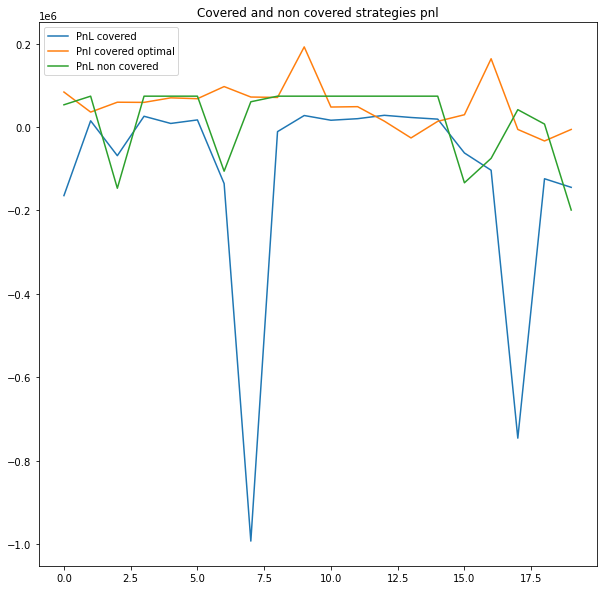

In [48]:
plt.figure(figsize=(10,10))
ax1 = plt.plot(pnl_covered,label="PnL covered")
ax2 = plt.plot(pnl_covered_optim,label="Pnl covered optimal")
ax3 = plt.plot(pnl_non_covered,label="PnL non covered")
plt.legend(loc="upper left")
plt.title("Covered and non covered strategies pnl")